# Part 1: GRASS GIS intro

In this first part, we will demonstrate starting GRASS GIS, creating new project and basic data visualization.

## Notebook environment

By default all cells are running Python:

In [15]:
# import sys
# v = sys.version_info
# print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.12.5


## Start GRASS GIS

Import Python standard library and IPython packages we need.

In [3]:
# import subprocess
# import sys

We're going to import the GRASS GIS python API (`grass.script`) and the GRASS GIS Jupyter package (`grass.jupyter`). But first, we need to find the path to those packages using the `--config python_path` command. This command is slightly different for each operating system.

Edit the box below to reflect your operating system and, if on Windows, your GRASS GIS version.

Now, we can use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [4]:
# FOR WINDOWS:
# grass_call = "grass82"
# shell_setting = True

# FOR MAC/LINUX
# grass_call = "/Applications/GRASS-8.4.app/Contents/Resources/bin/grass"
# shell_setting = False

In [1]:
import sys
sys.path.append('/Applications/GRASS-8.4.app/Contents/Resources/etc/python')

And now we can import the GRASS python packages!

In [ ]:
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("./../data",  "dix_park", "PERMANENT")

## Import data

<div class="alert alert-info">
If you are running this locally, download the data <a href="http://fatra.cnr.ncsu.edu/foss4g2021/">here</a> and put it in the same directory as this notebook.
</div>

We will import prepared digitial surface model (DSM), bare ground (digital terrain model, DTM) and ortho maps. 
The data CRS matches the CRS of the *dix_park* location, so we don't need to reproject it.

In [18]:
!r.import input=dsm.tif output=dsm resample=bilinear
!r.import input=ground.tif output=ground

Importing raster map <dsm>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
dsm - done
Importing raster map <ground>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
ground - done
Importing raster map <ortho>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
ortho - done


Next, we will import pre-downloaded OSM data of roads restricted to our study area. We obtained the roads using Overpass Turbo with this [query](https://overpass-turbo.eu/s/1aGu) and exported to GeoJSON. 

The data comes in EPSG:4326, so it will be automatically reprojected to UTM during the import.

In [26]:
!v.import input=roads.geojson output=roads

Importing <roads.geojson> ...
Check if OGR layer <roads> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <roads>...
Default driver / database set to:
driver: sqlite
database: $GISDBASE/$LOCATION_NAME/$MAPSET/sqlite/sqlite.db
Column name <@id> renamed to <xid>
Column name <tiger:cfcc> renamed to <tiger_cfcc>
Column name <tiger:county> renamed to <tiger_county>
Column name <tiger:name_base> renamed to <tiger_name_base>
Column name <tiger:name_base_1> renamed to <tiger_name_base_1>
Column name <tiger:name_direction_prefix> renamed to
<tiger_name_direction_prefix>
Column name <tiger:name_type> renamed to <tiger_name_type>
Column name <tiger:zip_left> renamed to <tiger_zip_left>
Column name <tiger:zip_right> renamed to <tiger_zip_right>
Importing 148 features (OGR layer <roads>)...

Let's look at the available data in our location:

In [27]:
!g.list type=raster,vector -m -t

raster/dsm@PERMANENT
raster/ground@PERMANENT
raster/ortho@PERMANENT
raster/viewshed@PERMANENT
vector/roads@PERMANENT


## Data visualization

We will call d.rast/d.vect modules using the [GRASS Jupyter API](https://grass.osgeo.org/grass-stable/manuals/libpython/grass.jupyter.html). The `Map` class creates and displays GRASS maps as static PNG images.

First let's display bare ground elevation with the roads dataset:

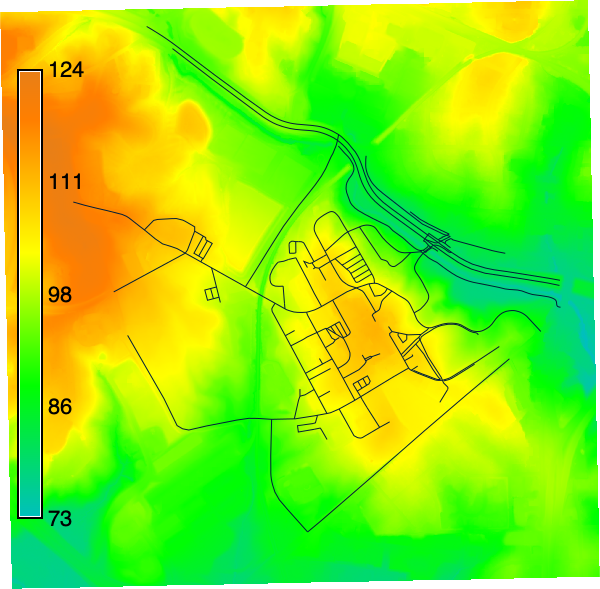

In [28]:
# Create Map instance
elevation_map = gj.Map()
# Add a raster and vector to the map
elevation_map.d_rast(map="ground")
elevation_map.d_vect(map="roads")
elevation_map.d_legend(raster="ground")
# Display map
elevation_map.show()

Next, display road _Umstead Drive_ in yellow on top of ortho. Method `d_vect` can be called with options of [d.vect](https://grass.osgeo.org/grass-stable/manuals/d.vect.html).

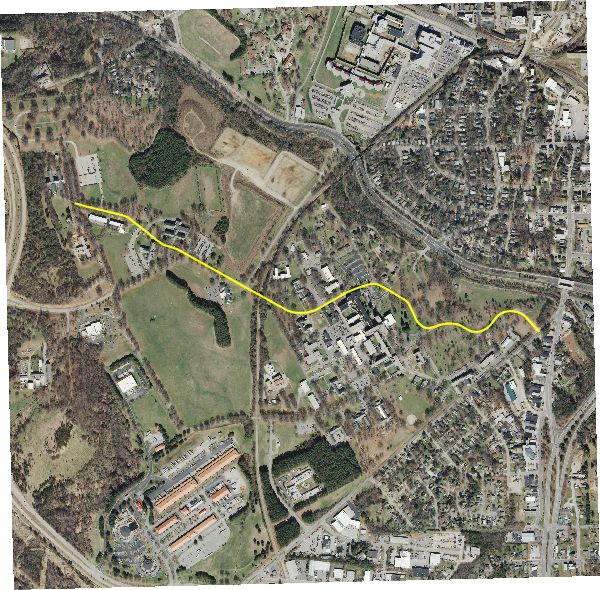

In [29]:
ortho_map = gj.Map()
ortho_map.d_rast(map="ortho")
ortho_map.d_vect(map="roads", width="2", color="yellow", where="name = 'Umstead Drive'")
ortho_map.show()

Here is how we can visualize data interactively with folium:


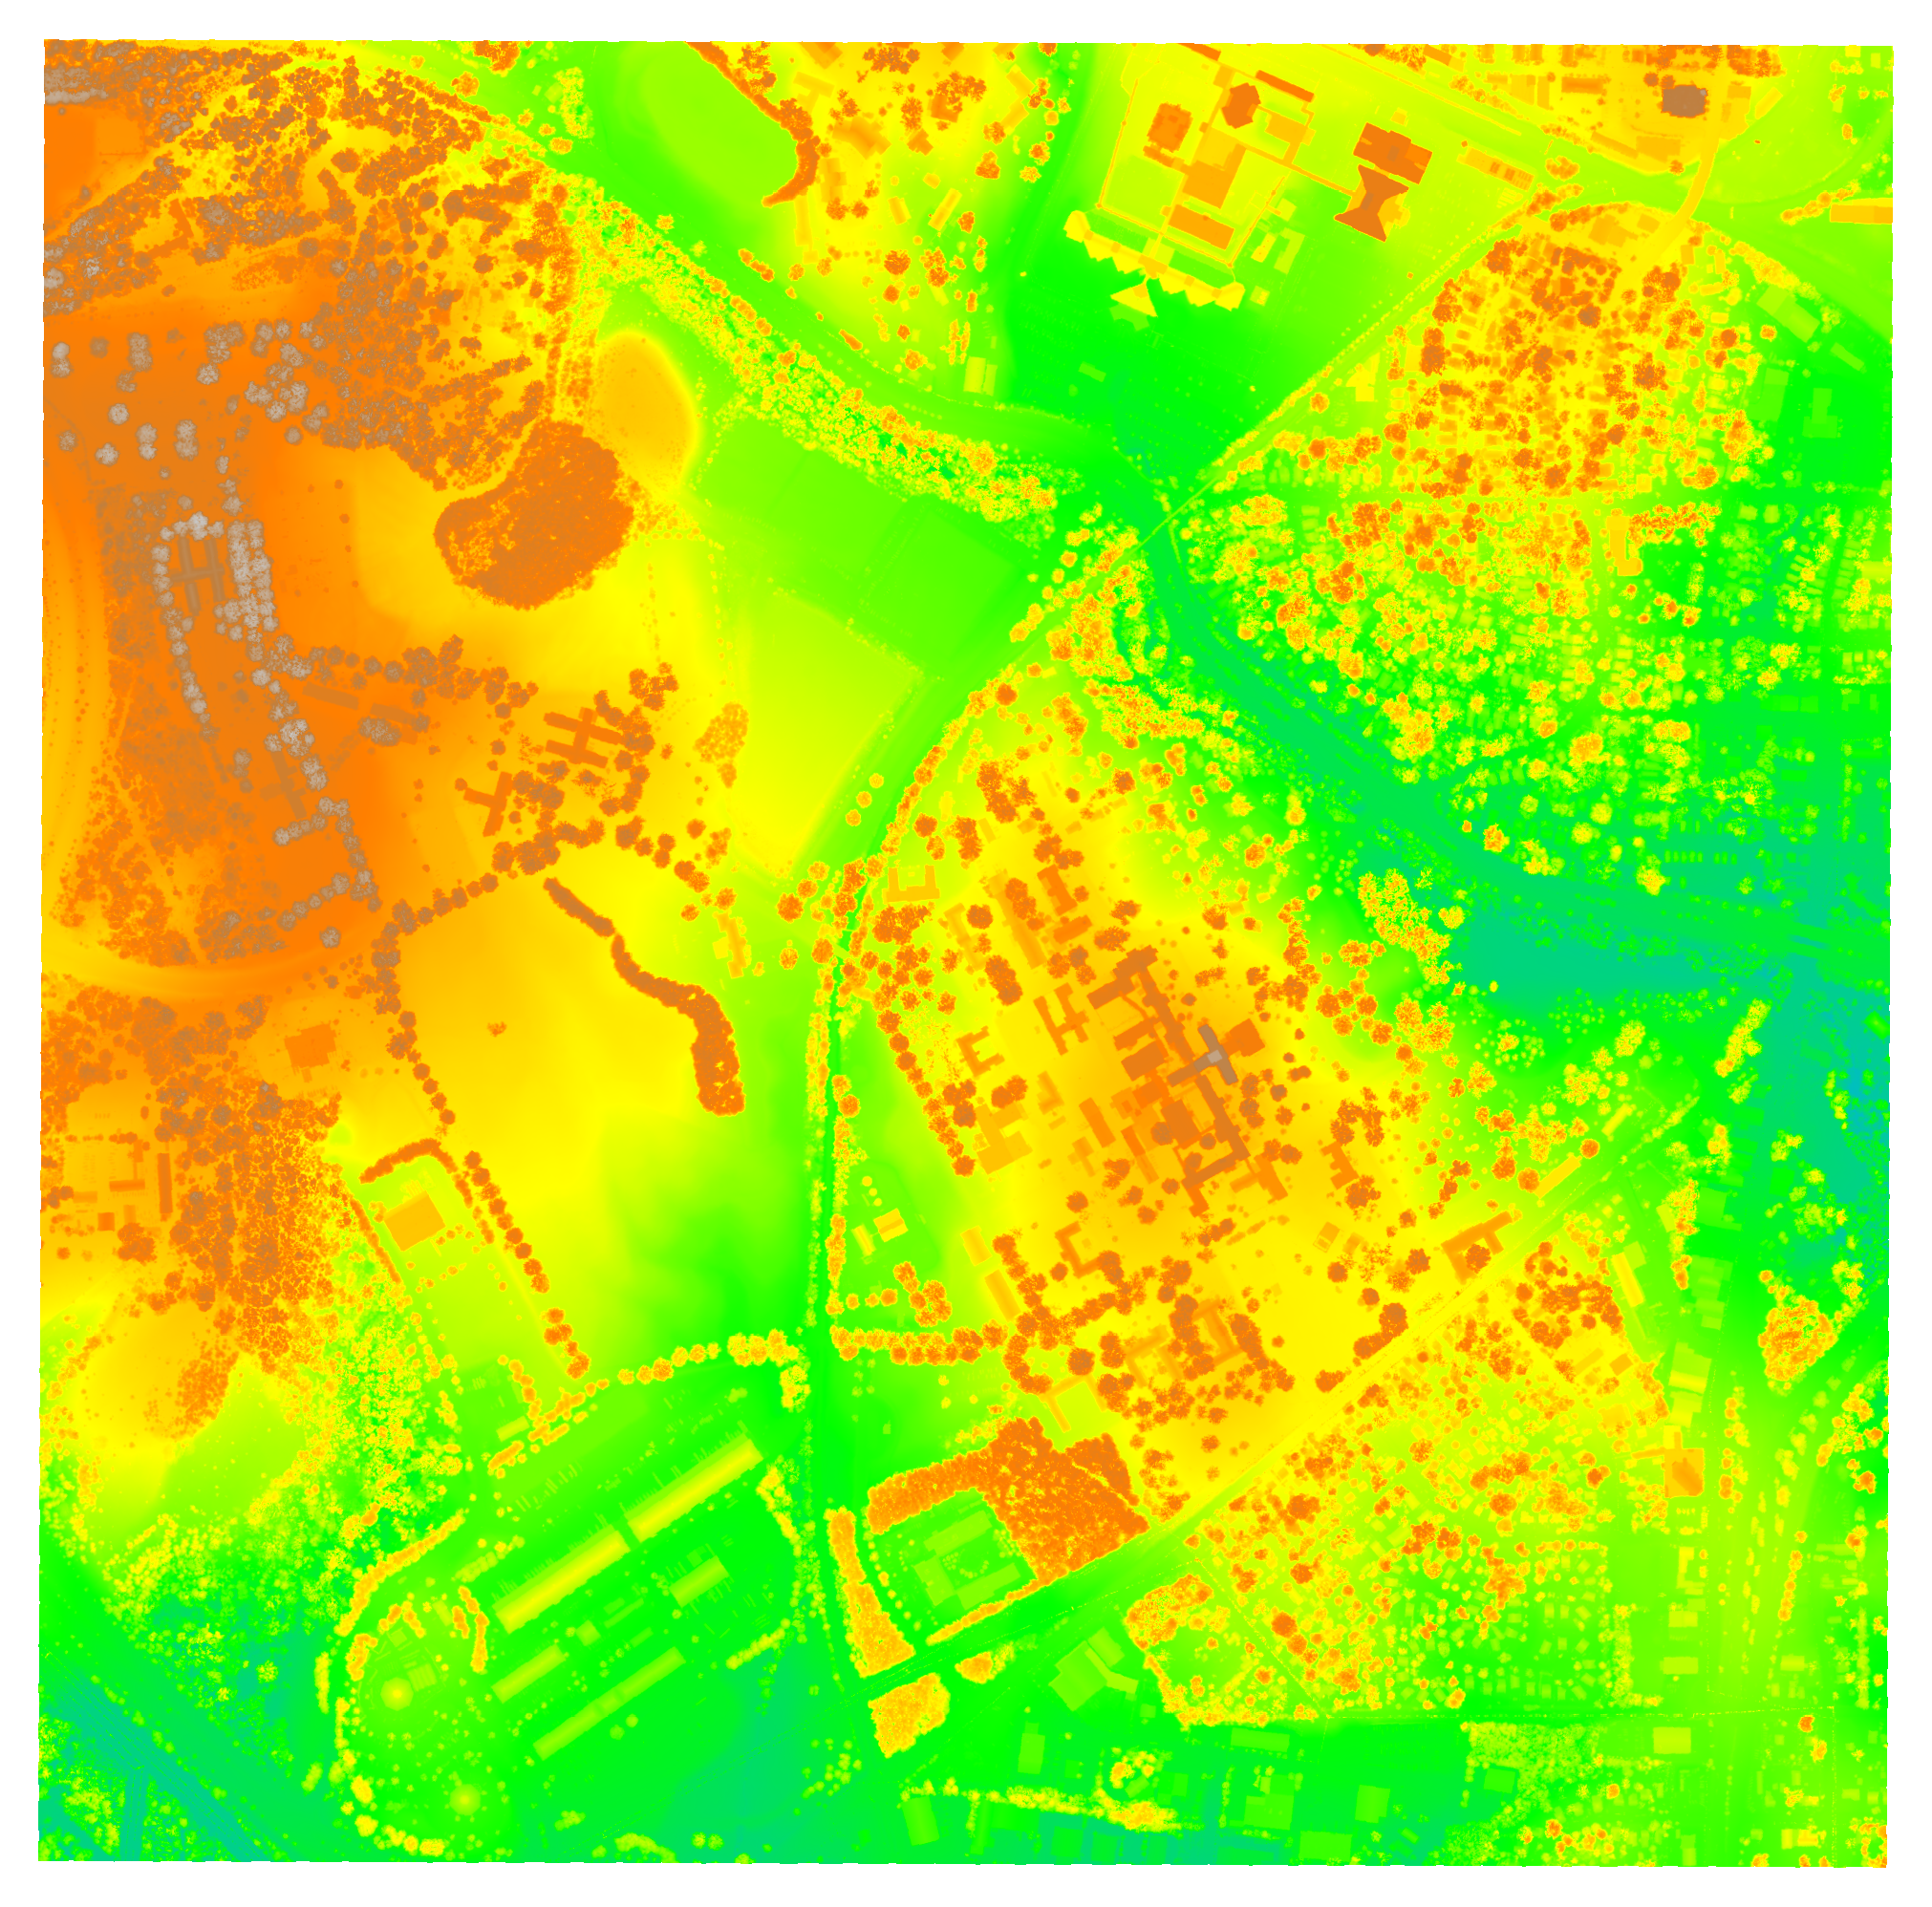

In [30]:
roads_map = gj.InteractiveMap()
roads_map.add_raster("dsm", opacity=0.5)
roads_map.add_vector("roads")
roads_map.add_layer_control(position="bottomright")
roads_map.show()

We can also visualize data in 3D. Here we drape the ortho over the DSM.


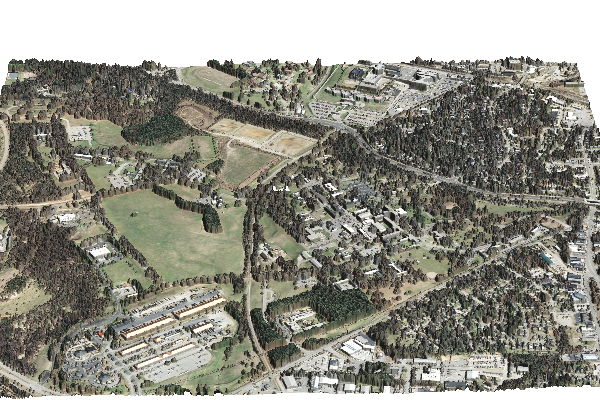

In [31]:
map3d = gj.Map3D()
map3d.render(elevation_map="dsm", color_map="ortho",
             position=(0.5, 1), height=3000, perspective=12)
map3d.show()

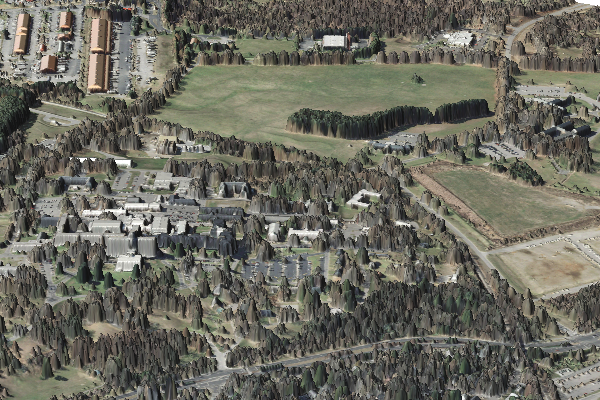

In [6]:
map3d = gj.Map3D()
map3d.render(elevation_map="dsm", resolution_fine=1, color_map="ortho",
             light_position=(1, 0, 0.5),
             position=(0.75, 0.35), height=1500, perspective=10)
map3d.show()

## GRASS GIS tools

GRASS functionality is available through tools (also called modules). There are over 500 different tools in the core distribution and over 300 addon tools that can be used to prepare and analyze data.

Tools respect the following naming conventions:

Prefix | Function | Example
------ | -------- | -------
r.* | raster processing | r.mapcalc: map algebra
v.*	| vector processing	| v.clean: topological cleaning
i.*	| imagery processing | i.segment: object recognition
db.* | database management | db.select: select values from table
r3.* | 3D raster processing | r3.stats: 3D raster statistics
t.* | temporal data processing | t.rast.aggregate: temporal aggregation
g.* | general data management | g.rename: renames map
d.* | display | d.rast: display raster map

Note also that some tools have multiple dots in their names. For example, tools staring with v.net.* deal with vector network analysis and r.in.* tools import raster data into GRASS GIS spatial database.

There is a tool for finding other tools:

In [24]:
!g.search.modules keyword=zonal


r.statistics
    keywords: raster,statistics,zonal statistics
    description: Calculates category or object oriented statistics.

r.stats.quantile
    keywords: raster,statistics,zonal statistics,percentile,quantile
    description: Compute category quantiles using two passes.

r.stats.zonal
    keywords: raster,statistics,zonal statistics
    description: Calculates category or object oriented statistics
                 (accumulator-based statistics).

r.univar
    keywords: raster,statistics,univariate statistics,zonal statistics,parallel
    description: Calculates univariate statistics from the non-null cells of a
                 raster map. Statistics include number of cells counted,
                 minimum and maximum cell values, range, arithmetic mean,
                 population variance, standard deviation, coefficient of
                 variation, and sum.

v.rast.stats
    keywords: vector,statistics,raster,univariate statistics,zonal
              statistics,sampling

Here is how to get all options and flags of a GRASS tool:

In [25]:
!r.univar --help

Calculates univariate statistics from the non-null cells of a raster map.

Usage:
 r.univar [-getr] map=name[,name,...] [zones=name] [output=name]
   [percentile=value[,value,...]] [nprocs=value] [separator=character]
   [--overwrite] [--help] [--verbose] [--quiet] [--ui]

Flags:
  -g   Print the stats in shell script style
  -e   Calculate extended statistics
  -t   Table output format instead of standard output format
  -r   Use the native resolution and extent of the raster map, instead of the current region

Parameters:
         map   Name of raster map(s)
       zones   Raster map used for zoning, must be of type CELL
      output   Name for output file (if omitted or "-" output to stdout)
  percentile   Percentile to calculate (requires extended statistics flag)
               options: 0-100
               default: 90
      nprocs   Number of threads for parallel computing
               default: 1
   separator   Field separator
               default: pipe


This will open the tool's manual page. It will work only locally.

```
g.manual r.univar
```

GRASS modules can be executed either through the GUI, command line or Python interfaces. This is an example how to execute a tool in command line. Specifically, it will extract road _Umstead Drive_ into a new vector `umstead_drive_segments`.

In [38]:
!v.extract input=roads where="name = 'Umstead Drive'" output=umstead_drive_segments

Extracting features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Building topology for vector map <umstead_drive_segments@PERMANENT>...
Registering primitives...
Writing attributes...


Now the same in Python:

In [39]:
gs.run_command("v.extract", input="roads", where="name = 'Umstead Drive'", output="umstead_drive_segments")

### Computational region

Computational region is an important raster concept in GRASS GIS, that allows you to fully control the extent and resolution of your raster computations.
All raster computations will be performed in the specified extent and with the given resolution to ensure consistency.
Among other things, computational region allows us to easily subset larger extent data for quicker testing of analysis, or to run an analysis of specific regions given by e.g. administrative units.

A few points to keep in mind:

 * computational region is defined by region extent and raster resolution
 * applies to all raster operations and vector to raster operations
 * persists between GRASS sessions, can be different for different mapsets (subprojects)
 * advantages: keeps your results consistent, avoids clipping, for computationally demanding tasks set region to smaller extent, check that your result is good and then set the computational region to the entire study area and rerun analysis

Run `g.region -p` to see current region settings:
 

In [32]:
!g.region -p

projection: 1 (UTM)
zone:       17
datum:      nad83_2011
ellipsoid:  grs80
north:      3961983
south:      3959992
west:       710677
east:       712704
nsres:      1
ewres:      1
rows:       1991
cols:       2027
cells:      4035757


The most common way to set region is **based on a raster map** - both extent and resolution. Run again g.region (we include -p flag to always see the resulting region):

In [33]:
!g.region -p raster=dsm

projection: 1 (UTM)
zone:       17
datum:      nad83_2011
ellipsoid:  grs80
north:      3961983
south:      3959992
west:       710677
east:       712704
nsres:      1
ewres:      1
rows:       1991
cols:       2027
cells:      4035757


Computational region can be set also **using a vector map**. In that case, only extent is set (as vector maps do not have any resolution - at least not in the way raster maps do). In the command line, it looks like this:


In [34]:
!g.region -p vector=roads

projection: 1 (UTM)
zone:       17
datum:      nad83_2011
ellipsoid:  grs80
north:      3961893.4610956
south:      3960184.78216542
west:       710924.14534659
east:       712571.13784047
nsres:      0.99981213
ewres:      0.99999544
rows:       1709
cols:       1647
cells:      2814723


However now the resolution was adjusted based on the extent of the vector map, it is no longer a nice rounded number. If that's not desired, we can set it explicitly using -a flag and parameter res. Now the resolution is aligned to even multiples of 2 (the units are the units of the current projection, in our case meters):


In [35]:
!g.region -p vector=roads res=2 -a

projection: 1 (UTM)
zone:       17
datum:      nad83_2011
ellipsoid:  grs80
north:      3961894
south:      3960184
west:       710924
east:       712572
nsres:      2
ewres:      2
rows:       855
cols:       824
cells:      704520


Often we need to set the computational extent based on a vector map, but alignment the resolution to a raster map:

In [36]:
!g.region -p vector=roads align=dsm

projection: 1 (UTM)
zone:       17
datum:      nad83_2011
ellipsoid:  grs80
north:      3961894
south:      3960184
west:       710924
east:       712572
nsres:      1
ewres:      1
rows:       1710
cols:       1648
cells:      2818080


Finally, we can save a specific region for later. This won't actually modify the current region:

In [40]:
!g.region vector=umstead_drive_segments align=dsm save=road_region

Saved region can be used later on, for example to set the rendering extent:

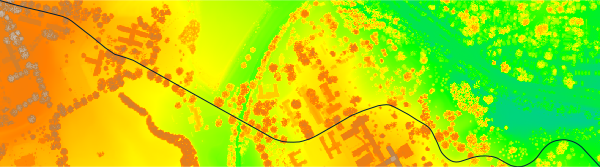

In [41]:
elevation_map = gj.Map(saved_region="road_region")
elevation_map.d_rast(map="dsm")
elevation_map.d_vect(map="umstead_drive_segments")
elevation_map.show()

## Python API

There are two Python APIs for accessing a tool's functionality - [GRASS GIS Python Scripting Library](https://grass.osgeo.org/grass-stable/manuals/libpython/script_intro.html) and [PyGRASS](https://grass.osgeo.org/grass-stable/manuals/libpython/pygrass_index.html).
PyGRASS is advantageous for more advanced workflows. Here we will be using Python Scripting Library (`import grass.script as gs`)
as it is simple and straightforward to use.
 

GRASS GIS Python Scripting Library provides functions to call GRASS modules within scripts as subprocesses. The most often used functions include:

 * [run_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.run_command): used with modules which output raster/vector data where text output is not expected
 * [read_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.read_command): used when we are interested in text output
 * [parse_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.parse_command): used with modules producing text output as key=value pair
 * [write_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.write_command): for modules expecting text input from either standard input or file


It also provides several wrapper functions for often called modules. The list of convenient wrapper functions with examples includes:

 * Raster metadata using [raster_info()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.raster.raster_info): `gs.raster_info('dsm')`
 * Vector metadata using [vector_info()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.vector.vector_info): `gs.vector_info('roads')`
 * List raster data in current location using [list_grouped()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.list_grouped): `gs.list_grouped(type=['raster'])`
 * Get current computational region using [region()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.region): `gs.region()`
 * Run raster algebra using [mapcalc()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.raster.mapcalc): `gs.mapcalc()`


### Let's practice!
Compute viewshed in Python.
1. Set computational region to match raster `dsm`:

In [42]:
gs.run_command("g.region", raster="dsm")

In [43]:
gs.region()

{'projection': 1,
 'zone': 17,
 'n': 3961983.0,
 's': 3959992.0,
 'w': 710677.0,
 'e': 712704.0,
 'nsres': 1.0,
 'ewres': 1.0,
 'rows': 1991,
 'cols': 2027,
 'cells': 4035757}

2. Compute binary viewshed (visible - 1, not visible - 0) using [r.viewshed](https://grass.osgeo.org/grass-stable/manuals/r.viewshed.html) using `dsm` raster from X=711260 and Y=3960860:

In [44]:
gs.run_command("r.viewshed", input="dsm", output="viewshed", flags="b", coordinates=(711260, 3960860))

3. Compute size of the visible area, using [r.univar](https://grass.osgeo.org/grass-stable/manuals/r.univar.html) computing univariate statistics. Use `gs.parse_command()` together with r.univar's `-g` flag to get a number of visible cells. Use `gs.region()` to get the cell size. Compute percentage of area that is visible.

In [45]:
univar = gs.parse_command("r.univar", map="viewshed", flags='g')

4. Display the viewshed overlaid over the orthophoto `ortho`. Use [d.rast](https://grass.osgeo.org/grass-stable/manuals/d.rast.html)'s `values` to display only visible cells.

In [ ]:
region = gs.region()
cell_size = region["nsres"] * region["ewres"]
percentage = 100 * float(univar['sum']) / float(univar['n'])
area = cell_size * float(univar['sum'])
print(f"Percentage of visible area is {percentage:.2f}%, which is {area / 10000:.2f} ha")


Percentage of visible area is 1.72%, which is 6.66 ha


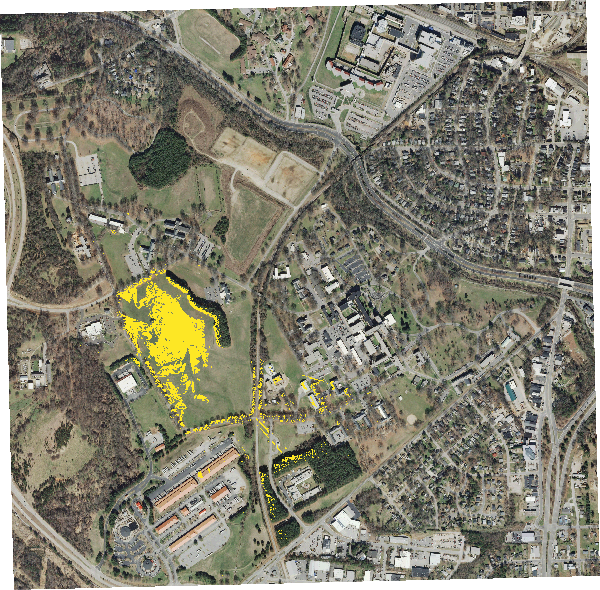

In [47]:
viewshed_map = gj.Map()
viewshed_map.d_rast(map="ortho")

# select only cells with value 1 to visualize
viewshed_map.d_rast(map="viewshed", values=1)
viewshed_map.show()

Find answers when you edit this cell.
<!--
# 1. set computational region based on DSM
gs.run_command("g.region", raster="dsm")
# 2. Compute viewshed, flag 'b' is for binary (0 and 1) output 
gs.run_command("r.viewshed", input="dsm", output="viewshed", flags="b", coordinates=(711260, 3960860))
# 3. Compute basic univariate statistics, flag 'g' is for parsable output
univar = gs.parse_command("r.univar", map="viewshed", flags='g')
# 4. Get current region settings to get cell size
region = gs.region()
cell_size = region["nsres"] * region["ewres"]
percentage = 100 * float(univar['sum']) / float(univar['n'])
area = cell_size * float(univar['sum'])
print(f"Percentage of visible area is {percentage:.2f}%, which is {area / 10000:.2f} ha")

viewshed_map = gj.Map()
viewshed_map.d_rast(map="ortho")
# select only cells with value 1 to visualize
viewshed_map.d_rast(map="viewshed", values=1)
viewshed_map.show()
-->